# <span style='color:red'>Project 2.  Due October 23</span>

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width: 90% !important; }</style>"))

### In this project we develop a first-order algorithm to construct a portfolio using intraday data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D


#### We will have data involving $n$ assets, and use the first $T$ days of the data to compute the portfolio.

#### The computation will produce a weight $x_i$ for each asset $i = 1,...,n$, which could be long or short.
#### We assume that on each day, a position is taken at the open, and closed at noon. So we define:

$$ p^o_{j,t} = \ \text{price of asset $j$ on day $t$ at the open}$$
$$ p^1_{j,t} = \ \text{price of asset $j$ on day $t$ at noon}$$
$$ r_{j,t} =  \ \frac{p^1_{j,t} - p^o_{j,t}}{p^o_{j,t}} = \ \text{return earned by asset $j$ on day $t$.}$$
$$ \bar r_j = \ \frac{1}{T} \sum_{t = 1}^T r_{j,t} = \ \text{average return earned by asset $j$.}$$

#### The optimization problem to solve depends on two parameters: $\theta \ge 0$ and $\pi > 0 0$.

####
$$ \text{minimize} \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)^{1/\pi}$$
#### 

#### There are no constraints on the quantities $x_j$.

#### The first sum is minus the average return earned by the portfolio. In the second sum, the quantity inside the square brackets is the excess return earned by the portfolio on day $t$, magnified by the power $\pi$. The quantity $\theta$ is a risk aversion parameter.
 

### <span style='color:red'> Task 1. Develop a first-order method to address this computational problem.</span>
#### 
#### Your method should work with values of $T$ at least $100$. Use the data we provide for AMZN, NFLX, TSLA, i.e., $n = 3$. 
###
#### Make sure your code works with $\pi = 0.5, 2, 4, 6$, and $\theta = 0.1, 10, 1000, 10^5, 10^6$.

In [3]:
def evalFun(x0, x1, x2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2):
    # quantity 1
    q1 = - ( x0*r0 + x1*r1 + x2*r2 )

    # quantity 2
    temp = ( np.abs(( (rt0 - r0) * x0 ) + ( (rt1 - r1) * x1 ) + ( (rt2 - r2) * x2 ))**pi )
    q2 = theta * ( (np.sum(temp) / T ) ** (1/pi) )

    return q1 + q2

In [4]:
def evalGrad(x0, x1, x2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2):

    # quantity 1 w.r.t x0, x1, x2
    q1_0 = - r0
    q1_1 = - r1
    q1_2 = - r2


    # quantity 2 w.r.t x0, x1, x2
    
    nt0 = rt0 - r0
    nt1 = rt1 - r1
    nt2 = rt2 - r2

    const = ( theta / T**(1/pi) ) * (1/pi)

    nt_all = (nt0 * x0) + (nt1 * x1) + (nt2 * x2)
    if pi == 0.5:
        nt_all = pi* ( np.abs(nt_all)**(pi-1) )
    else:
        nt_all = pi* ( nt_all**(pi-1) )

    q2_0 = const * ( ( np.sum( nt_all * nt0 ) ) ** ((1-pi)/pi) )
    q2_1 = const * ( ( np.sum( nt_all * nt1 ) ) ** ((1-pi)/pi) )
    q2_2 = const * ( ( np.sum( nt_all * nt2 ) ) ** ((1-pi)/pi) )

    return q1_0+q2_0 , q1_1+q2_1 , q1_2+q2_2

In [5]:
def backtrack(x0, x1, x2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2, fval, g0, g1, g2, delta0, delta1, delta2, loud):
    
    #fixed alpha and beta params!
    alpha = 0.5
    beta = 0.75

    gradtimesdelta = g0*delta0 + g1*delta1 + g2*delta2

    if loud:
        print('starting backtrack at x = ({:.3e},{:.3e},{:.3e}), f = {:.4e} and grad = ({:.3e},{:.3e},{:.3e}) and delta = ({:.3e},{:.3e},{:.3e})'.format(x0,x1,x2,fval,g0,g1,g2,delta0,delta1, delta2))
        print('grad times delta = {:.4e}'.format(gradtimesdelta))
    t = 1
    goon = True
    success = False

    while goon:
        fnew = evalFun(x0 + t*delta0, x1 + t*delta1, x2 + t*delta2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2)

        target = alpha*t*gradtimesdelta

        if loud:
            print('at t = {:.4e}, newx = ({:.5e},{:.5e},{:.5e}) and f = {:.4e}'.format(t, x0+t*delta0, x1 + t*delta1, x2 + t*delta2,fnew))
            print(' so function change = {:.4e} and target {:.4e}'.format(fnew-fval, target))

        if fnew - fval <= target:
            goon = False
            if loud:
                print('done!')
            success = True
        else:
            t = beta*t
        if t < 1e-8: #1e-4:
            if fnew < fval:
                print('well, we will take it\n')
                success = True
            goon = False
    return t, success

In [6]:
def run_grad_descent_momentum(x0, x1, x2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2, x0sol, x1sol, x2sol, fvalsol, N,  mu, loudbacktrack, loudsteps):
        
        converged = False 
        olddelta0 = olddelta1 = olddelta2 =  0

        for iteration in range(N):
            x0sol[iteration] = x0
            x1sol[iteration] = x1
            x2sol[iteration] = x2
            
            fval = evalFun(x0, x1, x2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2)
            
            fvalsol[iteration] = fval

            g0, g1, g2 = evalGrad(x0, x1, x2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2)
            if loudsteps or 0 == iteration%50:
                print('\nIteration', iteration)
                print('at x = ({:.3e}, {:.3e}, {:.3e}) function value = {:.4e} and gradient = ({:.5e}, {:.5e}, {:.5e})'.format(x0,x1,x2,fval,g0, g1, g2))
         
            t, goodstep = backtrack(x0,x1,x2,r0,r1,r2,theta,T,pi,rt0,rt1,rt2,fval,g0,g1,g2,-g0,-g1,-g2,loudbacktrack)
            
            if loudsteps:
                print('  got t = {:.4e} and goodstep = {}'.format(t, goodstep))
            if goodstep: 
                
                gradstep0 = -t*g0
                gradstep1 = -t*g1
                gradstep2 = -t*g2

                delta0 = gradstep0 + (1 - mu)*olddelta0
                delta1 = gradstep1 + (1 - mu)*olddelta1  #so mu = 1 gives usual step 
                delta2 = gradstep2 + (1 - mu)*olddelta2

                newx0 = x0 + delta0
                newx1 = x1 + delta1
                newx2 = x2 + delta2

                olddelta0 = delta0
                olddelta1 = delta1
                olddelta2 = delta2
 
                newfval = evalFun(newx0,newx1,newx2,r0,r1,r2,theta,T,pi,rt0,rt1,rt2)

                if loudsteps or 0 == iteration%50:
                    print('at new solution x = ({:.4e},{:.4e}, {:.4e}) function takes value {:.4e}'.format(newx0,newx1,newx2,newfval))

                x0 = newx0
                x1 = newx1
                x2 = newx2

                if g0**2 + g1**2 + g2**2 < 1.0e-15:
                    converged = True
                    break 

                
        print('\n*** Done at iteration {} and converged {} with final gradient ( {}, {}, {})\n'.format(iteration,converged, g0, g1, g2))
        return iteration

In [8]:
returns = pd.read_csv(r'/Users/abhishekmalichkar/Documents/Columbia University/returns.csv')
rt0, rt1, rt2 = returns['AMZN'].values, returns['NFLX'].values, returns['TSLA'].values


Iteration 0
at x = (3.000e-01, 4.000e-01, 5.000e-01) function value = 1.8510e-03 and gradient = (-5.85470e-04, 1.39353e-03, 9.65195e-04)
at new solution x = (3.0059e-01,3.9861e-01, 4.9903e-01) function takes value 1.8462e-03

Iteration 50
at x = (3.293e-01, 3.303e-01, 4.517e-01) function value = 1.6071e-03 and gradient = (-5.83497e-04, 1.39107e-03, 9.64911e-04)
at new solution x = (3.2990e-01,3.2890e-01, 4.5071e-01) function takes value 1.6021e-03

Iteration 100
at x = (3.580e-01, 2.609e-01, 4.036e-01) function value = 1.3682e-03 and gradient = (-5.85371e-04, 1.39382e-03, 9.64958e-04)
at new solution x = (3.5859e-01,2.5952e-01, 4.0265e-01) function takes value 1.3636e-03

Iteration 150
at x = (3.875e-01, 1.907e-01, 3.554e-01) function value = 1.1287e-03 and gradient = (-5.91165e-04, 1.40500e-03, 9.63423e-04)
at new solution x = (3.8809e-01,1.8928e-01, 3.5445e-01) function takes value 1.1240e-03

Iteration 200
at x = (4.171e-01, 1.210e-01, 3.068e-01) function value = 8.9346e-04 and gra

/var/folders/jl/3l5htvqs56v_nn7y6tpf56y40000gn/T/ipykernel_94685/2444954884.py:24: RuntimeWarning: invalid value encountered in scalar power
  q2_1 = const * ( ( np.sum( nt_all * nt1 ) ) ** ((1-pi)/pi) )



Iteration 250
at x = (-3.104e-01, 3.953e-01, 4.775e-01) function value = 7.7667e+00 and gradient = (-1.44473e-02, 5.80840e-03, -7.07805e-03)

*** Done at iteration 299 and converged False with final gradient ( -0.014447287879699858, 0.005808399402857021, -0.007078045531425483)


Iteration 0
at x = (3.000e-01, 4.000e-01, 5.000e-01) function value = 1.6282e+01 and gradient = (3.34514e+02, 2.85044e+02, 1.91731e+02)
well, we will take it

at new solution x = (3.0000e-01,4.0000e-01, 5.0000e-01) function takes value 1.6282e+01
well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we will take it

well, we wil

/var/folders/jl/3l5htvqs56v_nn7y6tpf56y40000gn/T/ipykernel_94685/2444954884.py:23: RuntimeWarning: invalid value encountered in scalar power
  q2_0 = const * ( ( np.sum( nt_all * nt0 ) ) ** ((1-pi)/pi) )
/var/folders/jl/3l5htvqs56v_nn7y6tpf56y40000gn/T/ipykernel_94685/2444954884.py:25: RuntimeWarning: invalid value encountered in scalar power
  q2_2 = const * ( ( np.sum( nt_all * nt2 ) ) ** ((1-pi)/pi) )



Iteration 250
at x = (-5.471e-01, -2.650e-01, 1.168e-01) function value = 1.0989e+04 and gradient = (nan, nan, nan)

*** Done at iteration 299 and converged False with final gradient ( nan, nan, nan)


Iteration 0
at x = (3.000e-01, 4.000e-01, 5.000e-01) function value = 3.0757e+04 and gradient = (2.65651e+10, 2.20545e+10, 1.10512e+10)

Iteration 50
at x = (3.000e-01, 4.000e-01, 5.000e-01) function value = 3.0757e+04 and gradient = (2.65651e+10, 2.20545e+10, 1.10512e+10)

Iteration 100
at x = (3.000e-01, 4.000e-01, 5.000e-01) function value = 3.0757e+04 and gradient = (2.65651e+10, 2.20545e+10, 1.10512e+10)

Iteration 150
at x = (3.000e-01, 4.000e-01, 5.000e-01) function value = 3.0757e+04 and gradient = (2.65651e+10, 2.20545e+10, 1.10512e+10)

Iteration 200
at x = (3.000e-01, 4.000e-01, 5.000e-01) function value = 3.0757e+04 and gradient = (2.65651e+10, 2.20545e+10, 1.10512e+10)

Iteration 250
at x = (3.000e-01, 4.000e-01, 5.000e-01) function value = 3.0757e+04 and gradient = (2.6565

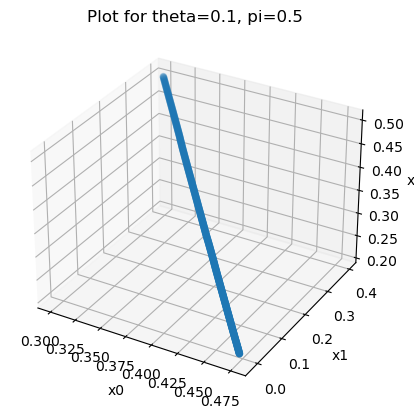

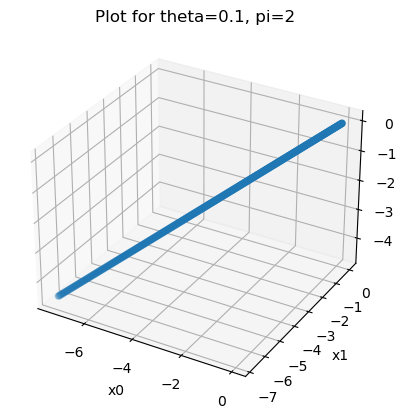

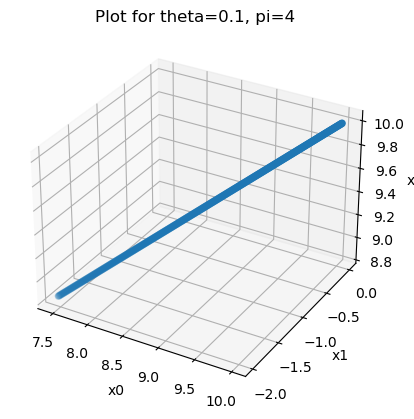

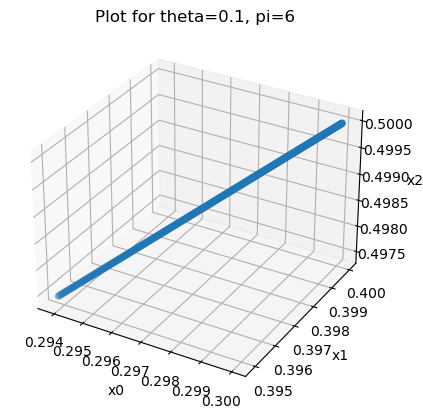

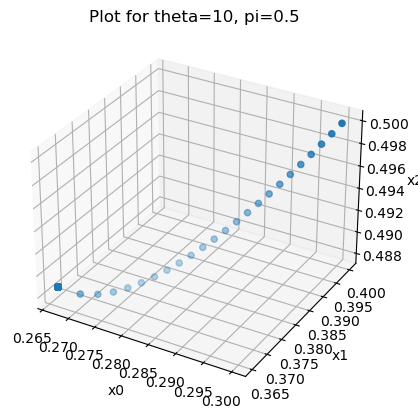

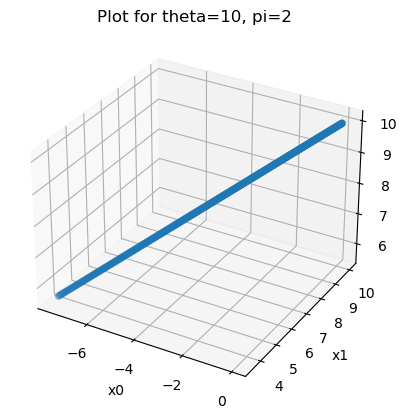

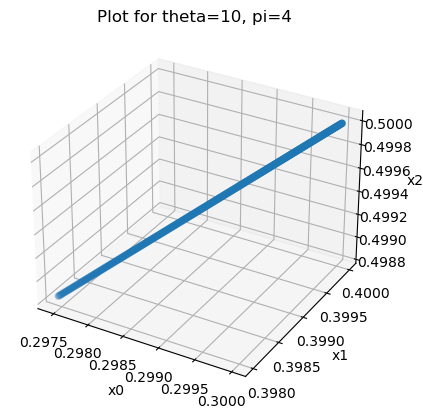

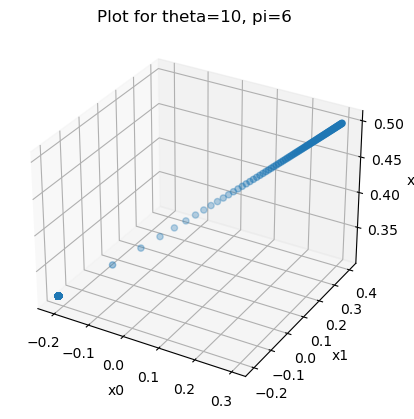

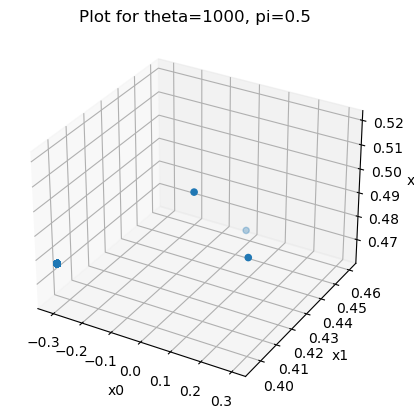

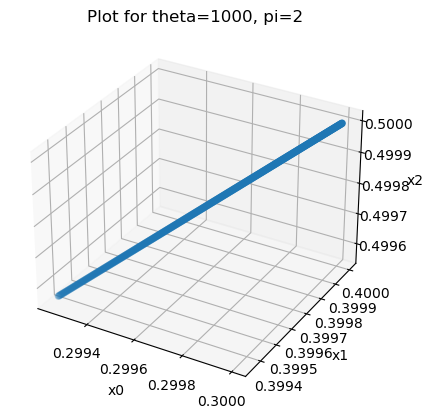

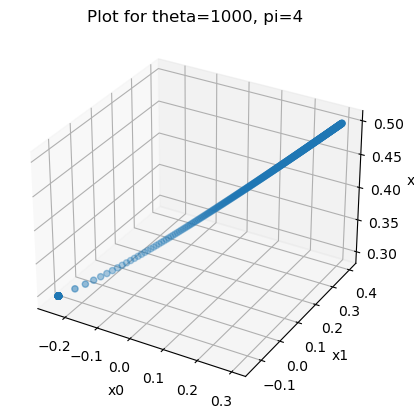

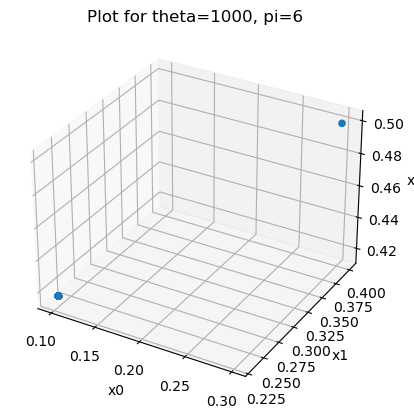

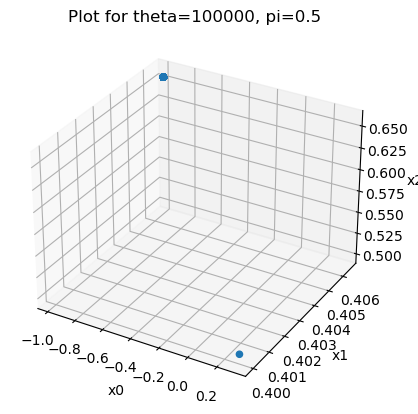

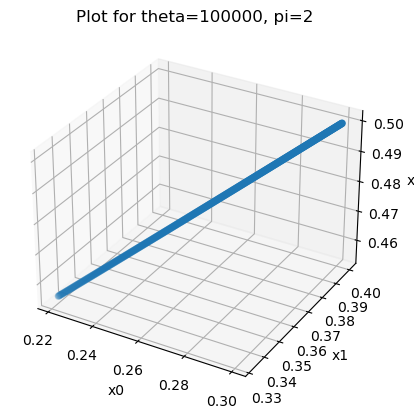

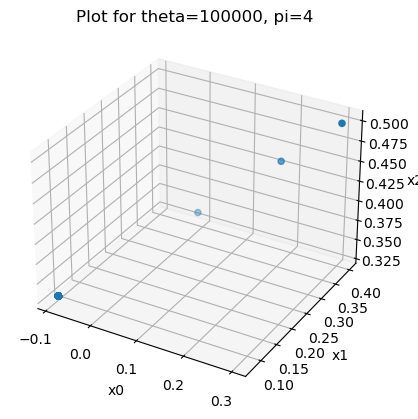

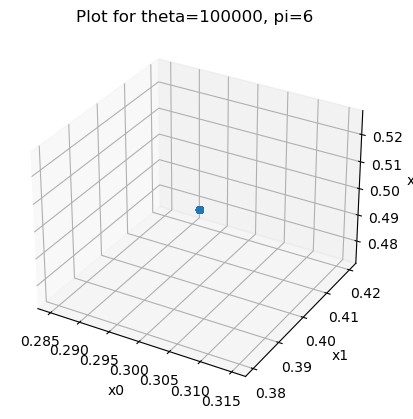

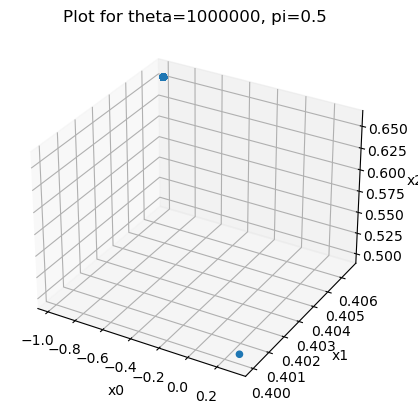

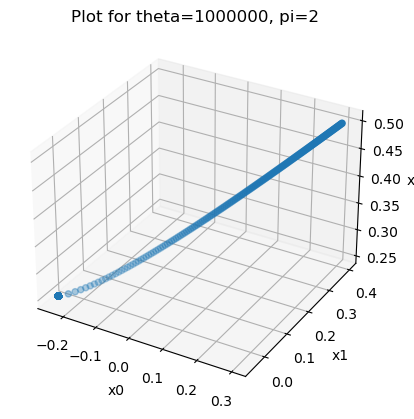

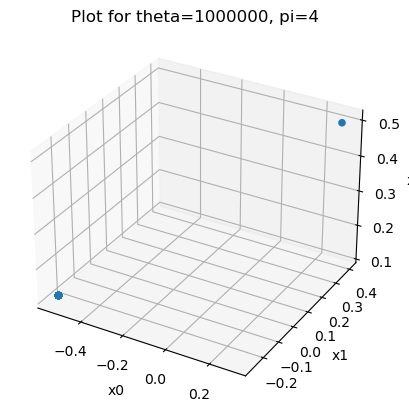

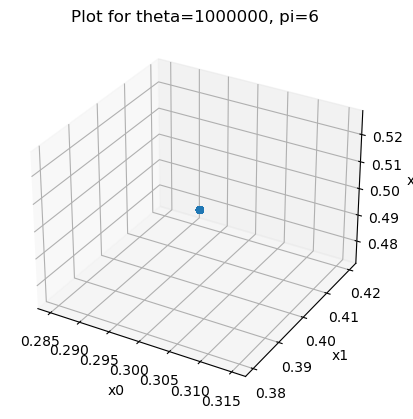

In [9]:
# initialize
x0, x1, x2 = 0.3, 0.4, 0.5

thetas = [0.1, 10, 1000, 10**5, 10**6]
T = 100
pis = [0.5, 2, 4, 6]
N = 300

rt0, rt1, rt2 = rt0[:T], rt1[:T], rt2[:T]
r0, r1, r2 = np.mean(rt0), np.mean(rt1), np.mean(rt2)

count = 0
results = {}

for theta in thetas:
    for pi in pis:
        x0sol = np.zeros(N)
        x1sol = np.zeros(N)
        x2sol = np.zeros(N)

        fvalsol = np.zeros(N)

        iteration = run_grad_descent_momentum(x0, x1, x2, r0, r1, r2, theta, T, pi, rt0, rt1, rt2, x0sol, x1sol, x2sol, fvalsol, N, 0.999, False, False)

        results[(theta, pi)] = (x0sol[iteration],x1sol[iteration], x2sol[iteration])

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x0sol[:iteration+1],x1sol[:iteration+1], x2sol[:iteration+1])

        ax.set_xlabel('x0')
        ax.set_ylabel('x1')
        ax.set_zlabel('x2')
        ax.set_title(f'Plot for theta={theta}, pi={pi}')

In [10]:
for result in results:
    print(f"For theta={result[0]}, pi={result[1]}: x0={results[result][0]:.5f}, x1={results[result][1]:.5f}, x2={results[result][2]:.5f}")

For theta=0.1, pi=0.5: x0=0.47599, x1=-0.01752, x2=0.21040
For theta=0.1, pi=2: x0=0.30000, x1=0.40000, x2=0.50000
For theta=0.1, pi=4: x0=0.29997, x1=0.39998, x2=0.49999
For theta=0.1, pi=6: x0=0.29387, x1=0.39490, x2=0.49745
For theta=10, pi=0.5: x0=0.26655, x1=0.36533, x2=0.48878
For theta=10, pi=2: x0=0.29999, x1=0.39999, x2=0.50000
For theta=10, pi=4: x0=0.29745, x1=0.39800, x2=0.49885
For theta=10, pi=6: x0=-0.21084, x1=-0.20480, x2=0.31105
For theta=1000, pi=0.5: x0=-0.31043, x1=0.39531, x2=0.47753
For theta=1000, pi=2: x0=0.29924, x1=0.39935, x2=0.49957
For theta=1000, pi=4: x0=-0.24557, x1=-0.14217, x2=0.29648
For theta=1000, pi=6: x0=0.09895, x1=0.23309, x2=0.41636
For theta=100000, pi=0.5: x0=-0.97990, x1=0.40646, x2=0.65607
For theta=100000, pi=2: x0=0.22104, x1=0.33277, x2=0.45526
For theta=100000, pi=4: x0=-0.08889, x1=0.07576, x2=0.33123
For theta=100000, pi=6: x0=0.30000, x1=0.40000, x2=0.50000
For theta=1000000, pi=0.5: x0=-0.98138, x1=0.40657, x2=0.65631
For theta=100

### <span style='color:red'>Task 2: Benchmark your portfolio on the remaining days</span>
#### On each of the remaining days, we proceed as follows.  Denote by $x^*$ your portfolio. At the market open we invest $10^9 x^*_j$ on each asset $j$, and we close the position (by) noon.  You need to use the asset's price to compute the number of shares that you invest in, whether long or short. So the total you invest equals $$ \sum_{j = 1}^n 10^9 |x^*_j|.$$
#### Report the average return earned by your portfolio.

In [11]:
returns = pd.read_csv(r'/Users/abhishekmalichkar/Documents/Columbia University/returns.csv')
rt0, rt1, rt2 = returns['AMZN'].values, returns['NFLX'].values, returns['TSLA'].values

remaining_days0, remaining_days1, remaining_days2 = rt0[T:], rt1[T:], rt2[T:]
r0, r1, r2 = np.mean(remaining_days0), np.mean(remaining_days1), np.mean(remaining_days2)

returns_obt = {}

for result in results:
    x0=results[result][0]
    x1=results[result][1]
    x2=results[result][2]
    
    total = x0 + x1 + x2
    scaled_x0 = x0/total
    scaled_x1 = x1/total
    scaled_x2 = x2/total

    avg_return = 10**9 *( r0*scaled_x0 + r1*scaled_x1 + r2*scaled_x2)

    returns_obt[(result[0], result[1])] = avg_return

    print(f"For theta={result[0]}, pi={result[1]} :")
    print(f"\t Returns made: {avg_return:.4f}")

For theta=0.1, pi=0.5 :
	 Returns made: 348364.5977
For theta=0.1, pi=2 :
	 Returns made: 12640.9276
For theta=0.1, pi=4 :
	 Returns made: 12611.9260
For theta=0.1, pi=6 :
	 Returns made: 4944.3530
For theta=10, pi=0.5 :
	 Returns made: -42566.0535
For theta=10, pi=2 :
	 Returns made: 12633.0927
For theta=10, pi=4 :
	 Returns made: 9705.3684
For theta=10, pi=6 :
	 Returns made: 9579021.5178
For theta=1000, pi=0.5 :
	 Returns made: -1274653.1972
For theta=1000, pi=2 :
	 Returns made: 11848.0489
For theta=1000, pi=4 :
	 Returns made: 10416548.6366
For theta=1000, pi=6 :
	 Returns made: -386662.6017
For theta=100000, pi=0.5 :
	 Returns made: -22167012.3067
For theta=100000, pi=2 :
	 Returns made: -86220.4061
For theta=100000, pi=4 :
	 Returns made: -1773504.1326
For theta=100000, pi=6 :
	 Returns made: 12641.0053
For theta=1000000, pi=0.5 :
	 Returns made: -22504052.6337
For theta=1000000, pi=2 :
	 Returns made: 21566642.1999
For theta=1000000, pi=4 :
	 Returns made: 1689336.9484
For thet

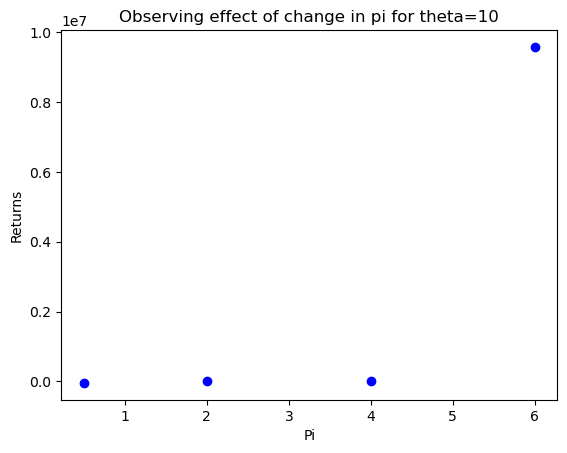

In [12]:
## Observing the change in returns due to change in pi for a fixed theta
## Fixing theta to 10

plt.figure()
plt.xlabel('Pi')
plt.ylabel('Returns')
plt.title('Observing effect of change in pi for theta=10')

for pi in pis:

    plt.scatter(pi , returns_obt[10, pi], color='blue', marker='o')


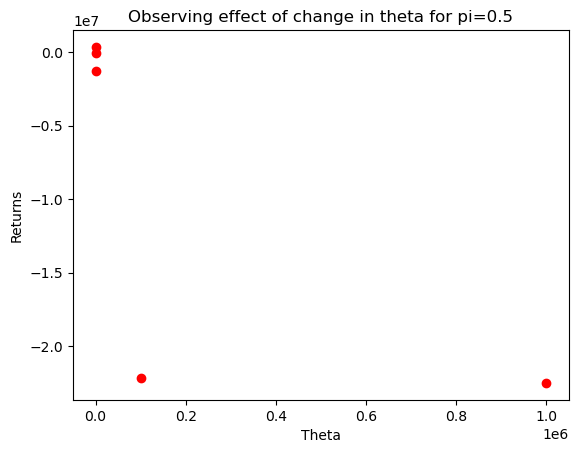

In [13]:
## Observing the change in returns due to change in theta for a fixed pi
## Fixing pi to 0.5

plt.figure()
plt.xlabel('Theta')
plt.ylabel('Returns')
plt.title('Observing effect of change in theta for pi=0.5')

for theta in thetas:
    plt.scatter(theta, returns_obt[theta, 0.5], color='red', marker='o')
